# FEM Modelling for Single-Phase STEDIN Transformer

### Voltage-fed Analysis - Non-Linear BH Curve

The nonlinear magnetic characteristic with hysteresis neglected can be approximated as given in [1].
\begin{equation}
    \frac{1}{\mu} = k_1 e^{k_2B^2} + k_3
\end{equation}
where, $k_1$, $k_2$ and $k_3$ are constants equal to 3.8, 2.17, and 396.2, respectively.

[1] J. Brauer, “Simple equations for the magnetization and reluctivity curves of steel,” IEEE Transactions on Magnetics, vol. 11, no. 1, pp. 81–81, 1975.

## Import Packages

In [1]:
print(" ▸ Loading Packages .... \r")
start = time_ns()
using gmsh
using LinearAlgebra
using LaTeXStrings
using Plots
using CSV
using DataFrames
include("../../../../lib/Makie_Plots.jl");
using .Makie_Plots
include("../../../../lib/FEM_VoltageFed_Tri_1e.jl");
using .FEM_VoltageFed_Tri_1e
include("../../../../lib/Post_Process_Frequency.jl");
using .Post_Process_Frequency
include("../../../../lib/Mesh_Data_stedin.jl");
using .Mesh_Data_stedin
include("../../../../lib/Save_VTK.jl");
using .Save_VTK
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Packages loaded ("*string(elapsed)*" seconds)                               ")

 ✓ Packages loaded (34.51 seconds)                               


## BH Curve

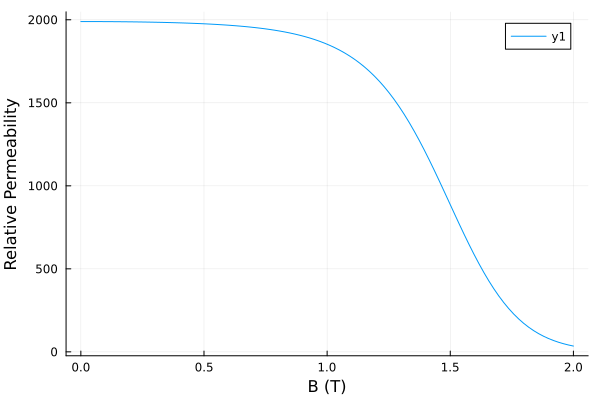

In [2]:
# Plot of mu vs B
mu0 = 4e-7 * pi;
function mu_func(B)
    k1 = 3.8;
    k2 = 2.17;
    k3 = 396.2;
    mu0 = 4e-7 * pi;
    v = k1 * exp(k2*B^2) + k3;
    return (1 ./ v)
end

B = collect(range(0, 2.0, 100))
plot(B,mu_func.(B)/mu0)
xlabel!("B (T)")
ylabel!("Relative Permeability")

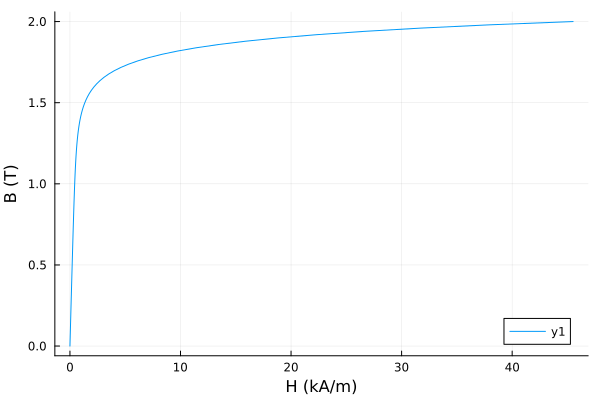

In [3]:
plot(B./mu_func.(B)/1000,B)
xlabel!("H (kA/m)")
ylabel!("B (T)")

## Julia code

In [4]:
gmsh.initialize()

## Read mesh from file
print(" ▸ Reading mesh file .... \r")
start = time_ns()
gmsh.open("../../../../Geometry/mesh/stedin_transformer.msh")
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Mesh file loaded ("*string(elapsed)*" seconds)                               ")

print(" ▸ Generating required mesh data .... \r")
start = time_ns()
mesh_data = get_mesh_data_tri_1e(gmsh)
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Mesh data generated ("*string(elapsed)*" seconds)                               ")

print(" ▸ Setting initial parameters .... \r")
start = time_ns()
Ip = 17.54;   # Primary peak phase current
Is = 777.62;  # Secondary peak phase current
Vp = 15202.40;   # Primary peak phase voltage
Vs = 342.93;     # Secondary peak phase voltage
Np = 266;
Ns = 6;

omega = 2*pi*50;  # Frequency

# HV winding dimensions (all phases left/right are identical)
wwhv = 3e-2;
hwhv = 74e-2;
mwhv = 14.75e-2;
Awhv = wwhv * hwhv;

# LV winding dimensions (all phases left/right are identical)
wwlv = 2e-2;
hwlv = 74e-2;
mwlv = 11.25e-2;
Awlv = wwlv * hwlv;

# Calculate turn density in the windings
Tp = Np / Awhv;
Ts = Ns / Awlv;

# Source turn density T
# One term for each of the windings, with a positive and negative part
sourcefunction(group_id) = [Tp*(1*(group_id==5))  -Tp*(1*(group_id==6))   Ts*(1*(group_id==11))  -Ts*(1*(group_id==12))];
sourceperelement = map(sourcefunction, mesh_data.e_group);

# Source voltage V
# One term for each of the windings, with a positive and negative part
coil_voltage = [Vp; Vp; 0; 0];

# External resistance Rext
# One term for each of the windings, with a positive and negative part
Rp = 150.655
Rs = 1.2999e-3
ext_resistance = [Rp; Rp; Rs; Rs];

# External resistance Rext
# One term for each of the windings, with a positive and negative part
ext_inductance = 1e-4.*[1; 1; 1; 1];

# Relative permeability model
mu0 = 4e-7 * pi;
mur = 2500;       # Relative permeability of the core
reluctivityfunction(group_id) = (1 / mu0) + (1/(mu0*mur) - 1/mu0) * (group_id == 2)
reluctivityperelement = map(reluctivityfunction, mesh_data.e_group);

# Conductivity
conductivityfunction(group_id) = 0;
conductivityperelement = map(conductivityfunction, mesh_data.e_group);

# Handle the boundary conditions
bnd_node_ids, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1);

elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Initial parameters set ("*string(elapsed)*" seconds)                               ")

mur_pts = findall(x->x==2, mesh_data.e_group)
L = LinearIndices(mesh_data.e_group)
mur_pts = L[mur_pts]
    
## Threshold value for the error
threshold = 1e-3
alpha = 0.9

u, Bx, By, B, Hx, Hy, H, mag_energy = (0, 0, 0, 0, 0, 0, 0, 0);

u = fem(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, coil_voltage, ext_resistance, ext_inductance);
u_hist = u
u_prev = u

@time for loop = 1:100
    u_prev = u;
    u_hist = u_hist * alpha + u * (1-alpha)
    
    # Post-process for magnetic field and current density
    Bx, By, B, Hx, Hy, H, mag_energy = post_process(mesh_data, u_hist[1:mesh_data.nnodes], reluctivityperelement);

    ## Assign new value of mur
    reluctivityperelement[mur_pts] = 1 ./ mu_func.(abs.(B[mur_pts]));
    
    # Calculate the vector potential
    u = fem(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, coil_voltage, ext_resistance, ext_inductance);
    
    display(norm(u[1:mesh_data.nnodes]-u_prev[1:mesh_data.nnodes]))
    
    ## Check the error with the threshold values
    if norm(u[1:mesh_data.nnodes]-u_prev[1:mesh_data.nnodes]) <= threshold
        break;
    end
end

# Post-process for magnetic field and current density
Bx, By, B, Hx, Hy, H, mag_energy = post_process(mesh_data, u[1:mesh_data.nnodes], reluctivityperelement);

print(" ▸ Saving Plots .... \r")
start = time_ns()
# Contour plot of the magnetic flux density
plot_surface_tri_1e(norm.(B), "single_phase_stedin_transformer_B_plot_nonlinear", gmsh)
# Contour plot of the magnetic field strength
plot_surface_tri_1e(norm.(H), "single_phase_stedin_transformer_H_plot_nonlinear", gmsh)
# Contour plot of the magnetic energy
plot_surface_tri_1e(norm.(mag_energy), "single_phase_stedin_transformer_mag_energy_plot_nonlinear", gmsh)
# Contour plot of the relative permeability
plot_surface_tri_1e((1 ./reluctivityperelement ./mu0), "single_phase_stedin_transformer_permeability_plot_nonlinear", gmsh)
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ Plots saved ("*string(elapsed)*" seconds)                               ")

print(" ▸ Saving VTK file .... \r")
start = time_ns()
# Save as VTK file for Paraview visualization
save_vtk(mesh_data, imag(u[1:mesh_data.nnodes]), norm.(B), norm.(H), norm.(mag_energy), reluctivityperelement, "single_phase_stedin_transformer_nonlinear")
elapsed = round((time_ns() - start)/10^9, digits=2)
println(" ✓ VTK file saved ("*string(elapsed)*" seconds)                               ")

gmsh.finalize()

Info    : Reading '../../../../Geometry/mesh/stedin_transformer.msh'...
Info    : 168 entities
Info    : 10385 nodes
Info    : 20768 elements
Info    : Done reading '../../../../Geometry/mesh/stedin_transformer.msh'
 ✓ Mesh file loaded (0.09 seconds)                               
 ✓ Mesh data generated (5.04 seconds)                               
 ✓ Initial parameters set (0.36 seconds)                               
 ✓ Matrices constructed (1.23 seconds)                               
 ✓ Solution computed (1.18 seconds)                               
 ✓ Post processing variables computed (1.19 seconds)                               
 ✓ Matrices constructed (0.24 seconds)                               
 ✓ Solution computed (0.07 seconds)                               


0.02527271598145613

 ✓ Post processing variables computed (0.07 seconds)                               
 ✓ Matrices constructed (0.18 seconds)                               
 ✓ Solution computed (0.07 seconds)                               


0.0018360565588148997

 ✓ Post processing variables computed (0.06 seconds)                               
 ✓ Matrices constructed (0.2 seconds)                               
 ✓ Solution computed (0.08 seconds)                               


0.0012839616564763584

 ✓ Post processing variables computed (0.09 seconds)                               
 ✓ Matrices constructed (0.29 seconds)                               
 ✓ Solution computed (0.09 seconds)                               


0.0009346530249051689

  3.999514 seconds (11.39 M allocations: 936.019 MiB, 4.82% gc time, 59.55% compilation time: 1% of which was recompilation)
 ✓ Post processing variables computed (0.07 seconds)                               
 ✓ Plots saved (28.9 seconds)                               
 ✓ VTK file saved (2.43 seconds)                               


### STEDIN Transformer : Magnetic field density
<img src="../img/single_phase_stedin_transformer_B_plot_nonlinear.png">

### STEDIN Transformer : Magnetic field strength
<img src="../img/single_phase_stedin_transformer_H_plot_nonlinear.png">

### STEDIN Transformer : Magnetic energy
<img src="../img/single_phase_stedin_transformer_mag_energy_plot_nonlinear.png">

### STEDIN Transformer : Relative permeability
<img src="../img/single_phase_stedin_transformer_permeability_plot_nonlinear.png">

In [5]:
display(maximum(norm.(B)))

1.210508962239212

In [6]:
display(norm.(B[7051]))

0.7833055539101405